# Libraries

In [138]:
import requests

import numpy as np
import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval

pd.set_option('display.max_columns', None) # display all columns in DF

# Uploading data

In [101]:
df_orangebook = pd.read_excel('Orange Book.xlsx', skiprows = 1)
df_openFDA_NDC = pd.read_csv('raw_openFDA_NDC_data.csv', sep = '~')  
df_medicaid = pd.read_csv('raw_medicaid_data.csv')
df_PPI = pd.read_excel('PPI industry data for Pharmaceutical preparation manufacturing.xlsx', skiprows = 10)

# Data manipulation

### OpenFDA NDC

Clearing nda

In [102]:
df_openFDA_NDC['NDA #'] = df_openFDA_NDC['application_number'].str.replace(r'\D', '')
df_openFDA_NDC['NDA #'] = pd.to_numeric(df_openFDA_NDC['NDA #'])

### Medicaid

Clearing labeler and product code

In [103]:
df_medicaid['labeler_code'] = pd.to_numeric(df_medicaid['labeler_code'])
df_medicaid['product_code'] = pd.to_numeric(df_medicaid['product_code'])

Creating a date

In [104]:
df_medicaid['date'] = 'Q' + df_medicaid['quarter'].astype(str) + ' ' + df_medicaid['year'].astype(str)
df_medicaid['date'] = pd.to_datetime(df_medicaid['date'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

### PPI

Creating a date

In [105]:
df_PPI['Period'] = df_PPI['Period'].str.replace(r'\D', '')
df_PPI['Period'] = pd.to_numeric(df_PPI['Period'])
df_PPI['day'] = 1
df_PPI['date'] = pd.to_datetime(dict(year = df_PPI['Year'], month = df_PPI['Period'], day= df_PPI['day']))

Calculating PPI multiplier

In [106]:
df_PPI['Value'] = pd.to_numeric(df_PPI['Value'])
df_PPI['PPI_multiplier'] = df_PPI['Value'].iloc[-1] / df_PPI['Value']

# Merging data

### Orange Book and OpenFDA

In [107]:
df = pd.merge(df_openFDA_NDC, df_orangebook, on = 'NDA #', how = 'left')

### Medicaid and PPI

In [108]:
df_medicaid = pd.merge(df_medicaid, df_PPI, on = 'date', how = 'left')

Adjusting for inflation

In [109]:
df_medicaid['price_per_unit_adj'] = df_medicaid['price_per_unit'] * df_medicaid['PPI_multiplier']

Deleting redundant columns

In [110]:
df_medicaid = df_medicaid.drop(columns=['Series ID', 'Year', 'Period', 'Value', 'Unnamed: 4', 'Unnamed: 5', 'day', 'PPI_multiplier'])

### Orange Book, OpenFDA and Medicaid

In [111]:
df_consolidation_data = pd.merge(df_medicaid, df_openFDA_NDC, on = ['labeler_code', 'product_code'], how = 'inner')

# Downloading output

In [112]:
df_consolidation_data.to_csv('raw_consolidation_data.csv', index = False)

### Descriptive statistics

In [113]:
df = df_consolidation_data

In [124]:
df_temp = df.drop_duplicates(subset = ['labeler_name', 'unique_id'])
df_temp = df_temp.groupby(['marketing_category'])['unique_id'].count()
df_temp = df_temp.reset_index()
df_temp

,marketing_category,unique_id
0,ANDA,6908
1,BLA,269
2,NDA,2039
3,NDA AUTHORIZED GENERIC,393


Number of unique drugs

In [115]:
df_temp = df.drop_duplicates(subset = ['unique_id'])
len(df_temp)

5412

Number of entrance (event) for unique drugs

In [139]:
df_temp = df.drop_duplicates(subset = ['labeler_name', 'unique_id'])
df_temp = df_temp.groupby(['unique_id'])['labeler_name'].count()
df_temp = df_temp.reset_index()
df_temp['entrance_count'] = pd.to_numeric(df_temp['labeler_name'])
df_temp['entrance_count'] = df_temp['entrance_count'] - 1
df_temp = df_temp.drop(columns = ['labeler_name'])
df_temp.sort_values(by = ['entrance_count'], ascending=False)

,unique_id,entrance_count
1658,Hydrocodone Bitartrate and Acetaminophen-TABLE...,16
1546,Gabapentin-CAPSULE-ORAL,15
240,Aripiprazole-TABLET-ORAL,13
946,"Daptomycin-INJECTION, POWDER, LYOPHILIZED, FOR...",13
1442,Fluconazole-TABLET-ORAL,12
...,...,...
2225,Metolazone-TABLET-ORAL,0
2226,"Metoprolol Succinate-CAPSULE, EXTENDED RELEASE...",0
2228,"Metoprolol Succinate-TABLET, FILM COATED, EXTE...",0
2229,Metoprolol Tartrate and Hydrochlorothiazide-TA...,0


In [148]:
df_temp['entrance_count'].value_counts(bins = 8, sort = False)

(-0.017, 2.0]    4888
(2.0, 4.0]        319
(4.0, 6.0]        123
(6.0, 8.0]         48
(8.0, 10.0]        25
(10.0, 12.0]        5
(12.0, 14.0]        2
(14.0, 16.0]        2
Name: entrance_count, dtype: int64

In [136]:
df_figure = df_temp.loc[df_temp['unique_id'] == 'Olanzapine-TABLET-ORAL']
df_figure

,unique_id,entrance_count
2514,Olanzapine-TABLET-ORAL,3


# First figure

In [116]:
df = df_consolidation_data

In [117]:
df.head(2)

,dataset,labeler_code,product_code,year,quarter,price_per_unit,date,price_per_unit_adj,product_ndc,generic_name,labeler_name,brand_name,finished,packaging,listing_expiration_date,openfda,marketing_category,dosage_form,spl_id,product_type,marketing_start_date,product_id,application_number,brand_name_base,marketing_end_date,active_ingredients,route,pharm_class,brand_name_suffix,dea_schedule,unique_id,NDA #
0,State Drug Utilization Data 1999,2,4112,1999,1,4.226167,1999-01-01,11.973026,0002-4112,Olanzapine,Eli Lilly and Company,Zyprexa,True,"[{'package_ndc': '0002-4112-30', 'description'...",20221231.0,{'manufacturer_name': ['Eli Lilly and Company'...,NDA,TABLET,d3dfec6e-4659-42ea-929f-7d9beb25a8a7,HUMAN PRESCRIPTION DRUG,19970623,0002-4112_d3dfec6e-4659-42ea-929f-7d9beb25a8a7,NDA020592,Zyprexa,NaN,"[{'name': 'OLANZAPINE', 'strength': '2.5 mg/1'}]",ORAL,['Atypical Antipsychotic [EPC]'],NaN,NaN,Olanzapine-TABLET-ORAL,20592.0
1,State Drug Utilization Data 1999,2,4112,1999,2,4.254315,1999-04-01,12.016049,0002-4112,Olanzapine,Eli Lilly and Company,Zyprexa,True,"[{'package_ndc': '0002-4112-30', 'description'...",20221231.0,{'manufacturer_name': ['Eli Lilly and Company'...,NDA,TABLET,d3dfec6e-4659-42ea-929f-7d9beb25a8a7,HUMAN PRESCRIPTION DRUG,19970623,0002-4112_d3dfec6e-4659-42ea-929f-7d9beb25a8a7,NDA020592,Zyprexa,NaN,"[{'name': 'OLANZAPINE', 'strength': '2.5 mg/1'}]",ORAL,['Atypical Antipsychotic [EPC]'],NaN,NaN,Olanzapine-TABLET-ORAL,20592.0


In [118]:
df_figure = df.loc[df['unique_id'] == 'Olanzapine-TABLET-ORAL']

In [119]:
df_figure = df_figure.groupby(['date', 'labeler_name'])['price_per_unit_adj'].mean()
df_figure = df_figure.reset_index()

In [120]:
df_figure

,date,labeler_name,price_per_unit_adj
0,1999-01-01,Eli Lilly and Company,15.390808
1,1999-04-01,Eli Lilly and Company,15.442688
2,1999-07-01,Eli Lilly and Company,15.129313
3,1999-10-01,Eli Lilly and Company,15.120320
4,2000-01-01,Eli Lilly and Company,18.521581
...,...,...,...
156,2020-10-01,"Virtus Pharmaceuticals, LLC",0.477556
157,2021-01-01,Aurobindo Pharma Limited,0.498138
158,2021-01-01,Eli Lilly and Company,19.330456
159,2021-01-01,Prasco Laboratories,0.481470


[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Price Per Unit Adj. for Inflation')]

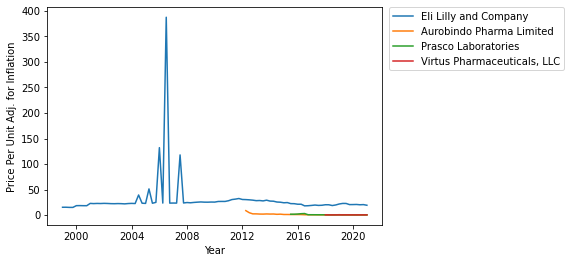

In [121]:
p = sns.lineplot(data = df_figure, x = 'date', y = 'price_per_unit_adj', hue = 'labeler_name', ci = 0)
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
p.set(xlabel = 'Year', ylabel = 'Price Per Unit Adj. for Inflation')

In [25]:
df_test.to_excel('output_for_one_drug.xlsx', index = False)